In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from multiprocessing import get_context
from multiprocessing import Process
from multiprocessing import Pool

In [2]:
BIDS_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH'

In [3]:
# only a subset of patients is used due to exclusion criteria
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

In [4]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [5]:
def get_all_files_of_type(BIDS_path, type_='.vhdr'):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(type_):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_files

In [6]:
vhdr_files = get_all_files_of_type(BIDS_path, '.vhdr')
tsv_files = get_all_files_of_type(BIDS_path, '.tsv')

In [6]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [7]:
def calc_epochs(bv_raw, y_tr, info, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    bv_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2)])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    n_epochs = bv_epoch.shape[0]
    events = np.empty((n_epochs, 3), dtype=int)


    event_id = dict(mov_present=1)

    for idx, i in enumerate(ind_mov):
        bv_epoch[idx,:] = bv_raw[i-epoch_lim:i+epoch_lim]
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]
        events[idx,:] = i, 0, event_id["mov_present"]
    print(bv_epoch.shape)
    bv_epoch = np.expand_dims(bv_epoch, axis=1)
    print(bv_epoch.shape)
    epochs = EpochsArray(data=bv_epoch, info=info, events=events, event_id=event_id)
    return epochs

In [8]:
def load_concat_dat(subject_id_, tsv_files, vhdr_files, best_ch, Con_, ECOG_):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """

    if best_ch == 'STN_LEFT_3':
        best_ch = 'STN_LEFT_2'
    if best_ch == 'STN_RIGHT_3':
        best_ch = 'STN_RIGHT_2'
    
    print(best_ch)
    if 'RIGHT' in best_ch:
        ses_patient = 'right'
    elif 'LEFT' in best_ch :
        ses_patient = 'left'
    
    runs_ = [file for file in tsv_files if 'sub-'+subject_id_ in file and 'ses-'+ses_patient in file and file.endswith('channels.tsv')]
    start = 0
    #print(runs_)
    for run in runs_:
        #print(run)
        df_run = pd.read_csv(run, sep="\t")
        if best_ch in list(df_run['name']):
            ind_data = np.where(df_run['name'] == best_ch)[0][0]
            run_number = run[run.find('run-')+4:run.find('_channels')] # is a string
            
            vhdr_file = 'sub-'+subject_id_+'_ses-'+ses_patient+'_task-force_run-'+str(run_number)+'_ieeg.vhdr'
            vhdr_path = [file for file in vhdr_files if vhdr_file in file][0]
                
            #print(vhdr_path)
            
            bv_raw, ch_names = read_BIDS_file(vhdr_path)

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_dat = np.arange(bv_raw.shape[0])[~np.isin(np.arange(bv_raw.shape[0]), ind_mov)]
            
            #print(ind_mov)
            mov_label = bv_raw[ind_mov, :] 
            
            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch, mov_channels, Con=Con_)
            
            print('best_ch: '+str(best_ch))
            print('mov_channels: '+str(mov_channels))
            print('mov_idx: '+str(mov_idx))
            label_ = mov_label[mov_idx,:]

            if start == 0: 
                start = 1 
                ch_dat = bv_raw[ind_data,:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, bv_raw[ind_data,:]), axis=0)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return ch_dat, mov_dat


In [9]:
def mutliprocess_tf(ch):
    print('subject: '+str(subject_id_)+ ' channel: '+str(ch))

    # z-score mov_dat and then apply the threshold 
    
    ch_dat, mov_dat = load_concat_dat(subject_id_, tsv_files, vhdr_files, ch, Con_, ECOG_)
    
    mov_dat = scipy.stats.zscore(mov_dat, axis=0)
    info = create_info(ch_names=[ch], sfreq=1000, ch_types='ecog')
    epochs = calc_epochs(ch_dat, mov_dat, info, threshold=1.5, epoch_lim=2500)


    freqs = np.arange(7, 200, 1)
    power = tfr_morlet(epochs, freqs=freqs,
                           n_cycles=5, return_itc=False, zero_mean=True, picks=0)
    dat = power.data[0,:,500:4500]  # cut off borders due to Wavelet transform
    dat_z = scipy.stats.zscore(dat, axis=1)
    
    np.save('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\ECOG_'+str(ECOG_)+'_Con_'+str(Con_)+\
           '_sub_'+str(subject_id_)+'_ch_'+str(ch)+'.npy', dat_z)

In [11]:
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  64


In [12]:
Con_ = False
ECOG_ = True
n_cycles = 5

# previously data was concatenated for every channel, 
# this json file is read, and subsequently the BIDS data is read and searched for that channel 
# then TF plots are estimated and saved 

for _, subject_id_ in enumerate(subject_id):
    if Con_ is False and subject_id_ == '013':
        continue
    print(subject_id_)
    
    # reading the patient_concat.json is done here only to get the used channels of a patient 
    # can be replaced by py_bids
    out_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\f_band_features_concatenated\LM_100ms\\'
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    
    channels = list(dict_ch.keys())
    for ch in channels:
        if ECOG_ is True and 'ECOG' in ch:
            mutliprocess_tf(ch)
        elif ECOG_ is False and 'STN' in ch:
            mutliprocess_tf(ch)
    #with Pool(processes=64) as pool:
    #    pool.map(mutliprocess_tf, list(dict_ch.keys()))

000
subject: 000 channel: ECOG_RIGHT_0
ECOG_RIGHT_0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin

Setting channel info structure...
best_ch: ECOG_RIGHT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(59, 5000)
(59, 1, 5000)
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
001
subject: 001 channel: ECOG_RIGHT_0
ECOG_RIGHT_0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:

subject: 001 channel: ECOG_RIGHT_7
ECOG_RIGHT_7
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
Not setting metadata
N

Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
Not setting metadata
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_RIGHT_15
ECOG_RIGHT_15
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-2_ieeg.vhdr...
Setting chann

Setting channel info structure...
best_ch: ECOG_RIGHT_21
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(125, 5000)
(125, 1, 5000)
Not setting metadata
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_RIGHT_22
ECOG_RIGHT_22
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters fro

Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-7_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
Not setting metadata
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_LEFT_1
ECOG_LEFT_1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN

Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-7_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
Not setting metadata
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_LEFT_6
ECOG_LEFT_6
Extracting parameters from C:\Users\ICN

Setting channel info structure...
best_ch: ECOG_LEFT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-7_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_10
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RI

Setting channel info structure...
best_ch: ECOG_LEFT_15
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_15
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_15
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_15
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RI

(121, 5000)
(121, 1, 5000)
Not setting metadata
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_LEFT_20
ECOG_LEFT_20
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_20
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_20
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info st

Setting channel info structure...
best_ch: ECOG_LEFT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(121, 5000)
(121, 1, 5000)
Not setting metadata
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 001 channel: ECOG_LEFT_25
ECOG_LEFT_25
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_25
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_25
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\User

Setting channel info structure...
best_ch: ECOG_RIGHT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(56, 5000)
(56, 1, 5000)
Not setting metadata
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 004 channel: ECOG_RIGHT_4
ECOG_RIGHT_4
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-004\ses-right\ieeg\sub-004_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-004\ses-right\ieeg\sub-004_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(56, 5000)
(56, 1, 5000)
Not sett

0 projection items activated
0 bad epochs dropped
subject: 005 channel: ECOG_RIGHT_1
ECOG_RIGHT_1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-005\ses-right\ieeg\sub-005_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(42, 5000)
(42, 1, 5000)
Not setting metadata
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 005 channel: ECOG_RIGHT_2
ECOG_RIGHT_2
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-005\ses-right\ieeg\sub-005_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(42, 5000)
(42, 1, 5000)
Not setting metadata
Not setting metadata
42 matching 

Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(97, 5000)
(97, 1, 5000)
Not setting metadata
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 005 channel: ECOG_LEFT_4
ECOG_LEFT_4
Extracting parameters from C:\Users\ICN_ad

Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', '

Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_7
ECOG_RIGHT_7
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: E

Setting channel info structure...
best_ch: ECOG_RIGHT_12
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_13
ECOG_RIGHT_13
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_13
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters fro

Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_19
ECOG_RIGHT_19
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters fro

Setting channel info structure...
best_ch: ECOG_RIGHT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_24
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(104, 5000)
(104, 1, 5000)
Not setting metadata
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_25
ECOG_RIGHT_25
Extracting parameters fro

Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_34
ECOG_RIGHT_34
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_34
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(27, 5000)
(27, 1, 5000)
Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_RIGHT_35
ECOG_RIGHT_35
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_35
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx

Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
Not setting metadata
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_LEFT_7
ECOG_LEFT_7
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_7
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_ad

Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_LEFT_14
ECOG_LEFT_14
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['

Setting channel info structure...
best_ch: ECOG_LEFT_21
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-5_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_21
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
Not setting metadata
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_LEFT_22
ECOG_LEFT_22
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_22
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\I

(85, 5000)
(85, 1, 5000)
Not setting metadata
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 006 channel: ECOG_LEFT_29
ECOG_LEFT_29
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_29
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_29
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-006\ses-left\ieeg\sub-006_ses-left_task-force_run-5_ieeg.vhdr...
Setting channel info struc

0 bad epochs dropped
subject: 007 channel: ECOG_LEFT_1
ECOG_LEFT_1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-007\ses-left\ieeg\sub-007_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(38, 5000)
(38, 1, 5000)
Not setting metadata
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 007 channel: ECOG_LEFT_2
ECOG_LEFT_2
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-007\ses-left\ieeg\sub-007_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(38, 5000)
(38, 1, 5000)
Not setting metadata
Not setting metadata
38 matching events found
No baseline correction app

Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
(53, 5000)
(53, 1, 5000)
Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 009 channel: ECOG_LEFT_1
ECOG_LEFT_1
Extracting parameters from C:\Users\ICN_ad

Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-4_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_

(205, 5000)
(205, 1, 5000)
Not setting metadata
Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 010 channel: ECOG_LEFT_1
ECOG_LEFT_1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-4_ieeg.vhdr...
Setting channel info struct

Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-7_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 1
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-8_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_

Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-014\ses-right\ieeg\sub-014_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
Extracting parameters from C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH\sub-014\ses-right\ieeg\sub-014_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
mov_idx: 0
(69, 5000)
(69, 1, 5000)
Not setting metadata
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
subject: 014 channel: ECOG_RIGHT_5
ECOG_RIGHT_5
Extracting parameters from C:\Use

In [13]:
files = os.listdir('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\')
files_ECOG_Con = [file for file in files if 'ECOG_True' in file and 'Con_True' in file]
l = []
for file in files_ECOG_Con:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
ECOG_CON = np.array(l).mean(axis=0)

files_ECOG_Ips = [file for file in files if 'ECOG_True' in file and 'Con_False' in file]
l = []
for file in files_ECOG_Ips:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
ECOG_Ips = np.array(l).mean(axis=0)

files_STN_Con = [file for file in files if 'ECOG_False' in file and 'Con_True' in file]
l = []
for file in files_STN_Con:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
STN_CON = np.array(l).mean(axis=0)

files_STN_Ips = [file for file in files if 'ECOG_False' in file and 'Con_False' in file]
l = []
for file in files_STN_Ips:
    l.append(np.load('C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 1\\TF_dat\\'+file))
STN_Ips = np.array(l).mean(axis=0)


In [14]:
FIGURE_1C = {
    "ECOG_CON" : ECOG_CON,
    "ECOG_Ips" : ECOG_Ips,
    "STN_CON" :  STN_CON,
    "STN_Ips" : STN_Ips}

In [6]:
from scipy import io

In [15]:
io.savemat('Figure_1C.mat', FIGURE_1C)

In [10]:
FIGURE_1C = io.loadmat('Figure_1C.mat')

In [11]:
ECOG_CON = FIGURE_1C["ECOG_CON"]
ECOG_Ips = FIGURE_1C["ECOG_Ips"]
STN_CON = FIGURE_1C["STN_CON"]
STN_Ips = FIGURE_1C["STN_Ips"]

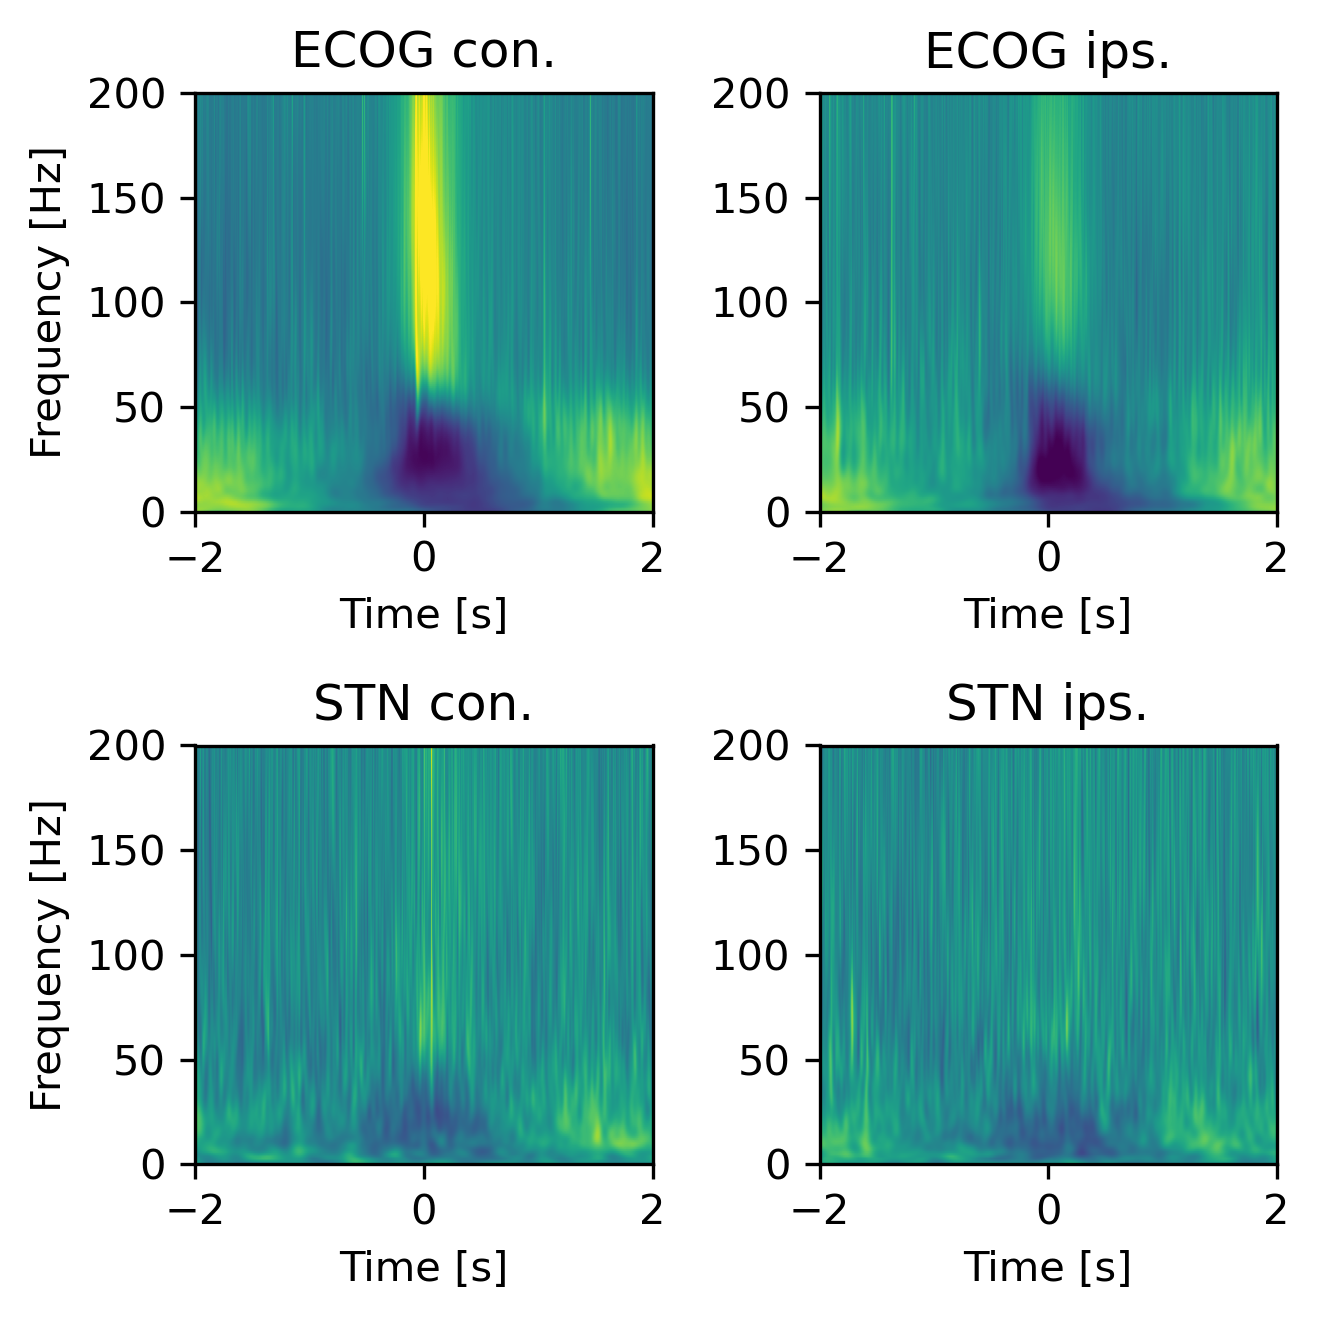

In [14]:
#plt.style.use('dark_background')
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(4.5,4.5), dpi=300)
for idx, dat_ in enumerate([ECOG_CON, ECOG_Ips, STN_CON, STN_Ips]):
    plt.subplot(2,2,idx+1)
    plt.imshow(dat_, aspect='auto', extent=[-2,2,200,0])#, cmap='hot')
    #cbar = plt.colorbar()
    #cbar.set_label('Spectral Power [VAR]')
    #plt.clim(0.5,1.2)
    plt.clim(-1.5, 1.5)
    plt.gca().invert_yaxis()
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig("Figure 1 TF Plot.pdf", bbox_inches='tight', dpi=300)